# Imbalanced Learning

Estudo baseado no livro "Imbalanced Learning" (https://drive.google.com/file/d/1k0n0xg8jvDOOX0Fwj9nteVR16q3Gu2bJ/view?usp=sharing) e na biblioteca IL (http://contrib.scikit-learn.org/imbalanced-learn/stable/)

In [19]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
%matplotlib inline

#selecionando atributos 
from sklearn.feature_selection import RFECV

#resample
from sklearn.utils import resample

#SELECIONANDO MELHOR MODELO
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Evaluating
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#EXPORTAR ARVORE
from sklearn.tree import export_graphviz
import os

#CURVA ROC
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

#definindo score
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

#exibindo todas as colunas
pd.set_option('display.max_columns', None)



In [38]:
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')
    
def evaluating(model, ytest, ypred, Xtest):
    #matriz de confusao (AP: atual positivo, AN: atual negativo, PP: pred. positivo, PN: pred. negativo)
    #     AN | AP 
    # --------------
    # PN: TN | FN
    # PP: FP | TP

    #Text summary of the precision, recall, F1 score for each class
    #precision = TP/(TP+FP); TN/(TN+FN) 
    #recall    = TP/(TP+FN); TN/(TN+FP)
    print(classification_report(ytest, ypred))    
    
    #Evaluating
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    #tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()    
    #print(tp)
    #print(tn)
    #print(fn)
    #print(fp)
    #print( tn/(tn+fp) )
    
    #CURVA ROC
    fig = plt.figure()
    y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 

    y_scores = y_probas[:, 1]   # score = proba of positive class 
    fpr, tpr, thresholds = roc_curve(ytest, y_scores)

    plot_roc_curve(fpr, tpr) 
    plt.show()
    print("AUC: %f" % roc_auc_score(ytest, y_scores))
    
#limpando os NaN devido ao RF
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    #print(dados_clean.info())
    
    return (dados_clean, y)

def feature_ranking(Xtest, model, std):
    #exibe os atributos mais importantes
    importances = model.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(Xtest.shape[1]):
        print("%d. feature %d [%s] (%f)" % (f + 1, indices[f], Xtest.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(Xtest.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(Xtest.shape[1]), indices)
    plt.xlim([-1, Xtest.shape[1]])
    plt.show() 

In [3]:
dados_tunning = pd.read_json('dados/dados_workflow_ivan.json')
dados_tunning.head(2)

,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90H_dependencia,LnguaPortuguesaeLiteraturaI90H_freq,MatemticaI120H,MatemticaI120H_dependencia,MatemticaI120H_freq,acompanhamento,aluno_exclusivo_rede_publica,artificial,classe,conceito,conceito_freq,descricao,descricao_area_residencial,descricao_companhia_domiciliar,descricao_estado_civil,descricao_historico,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_trabalho,id,idade,pessoa_fisica__sexo,possui_necessidade_especial,qnt_pc,qnt_salarios,qtd_pessoas_domicilio,sigla,tempo_entre_conclusao_ingresso
0,68.0,0,100.0,66.0,0,100.0,0,False,0,1,B,A,Matriculado,Urbana,Mãe,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Branca,Ensino fundamental incompleto,Mãe,Não informado,457884597605,15,F,False,0,1,2,LAJ,1
1,73.0,1,100.0,36.0,1,91.0,0,False,1,0,R,R,Cancelado,Urbana,Mãe,Solteiro(a),Técnico de Nível Médio em Meio Ambiente,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Parda,Ensino fundamental incompleto,Mãe,Não informado,458436647741,17,M,False,1,1,2,SPP,2


# Cenário 01: são utilizado todos os dados (notas, caracterização social, demográficos) e a técnica DT

In [4]:
dados = dados_tunning.copy()

atributos = [
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

#recupera apenas os dados que nao foram criados de forma artificial
dados = dados[dados.artificial == 0]

print(dados.classe.value_counts())

1    7369
0     349
Name: classe, dtype: int64


In [5]:
X, y = preparing_data(dados)
print(X.shape)

#separa o conjunto de treinamento e teste de acordo com o balanceamento das classes. 
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

(7718, 31)
(7718, 31)
(7718, 151)


In [6]:
#técnica selecionada DT com parâmetros otimizados de acordo com a score 
tree_clf = DecisionTreeClassifier() 

param_grid_tree = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 3, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

#seleciona o melhor modelo de acordo com os parâmetros
grid_search_tree = GridSearchCV(estimator=tree_clf, param_grid=param_grid_tree, scoring='roc_auc')
grid_search_tree.fit(Xtrain, ytrain)

model_tree = grid_search_tree.best_estimator_
ypred_tree = model_tree.predict(Xtest)



             precision    recall  f1-score   support

          0       0.79      0.38      0.51        87
          1       0.97      1.00      0.98      1843

avg / total       0.96      0.97      0.96      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


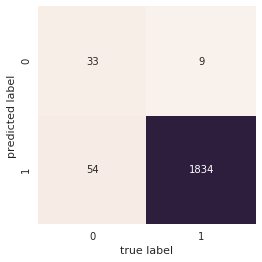

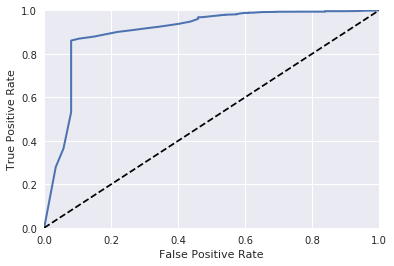

AUC: 0.902346


In [36]:
evaluating(model_tree, ytest, ypred_tree, Xtest)

# Cenário 02: técnica BalancedBaggingClassifier

{'n_estimators': 100}
0.9263815722225228
             precision    recall  f1-score   support

          0       0.33      0.89      0.48        87
          1       0.99      0.91      0.95      1843

avg / total       0.96      0.91      0.93      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


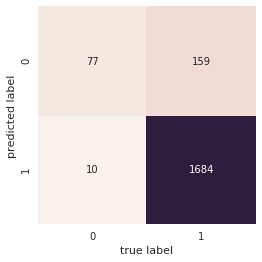

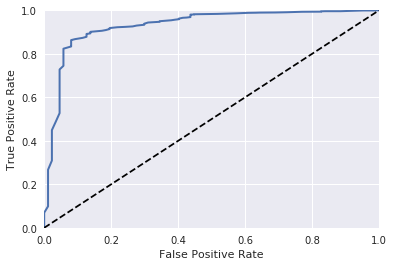

AUC: 0.930988


In [37]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_validate

#classificador base DT
tree = DecisionTreeClassifier(max_features='auto')

#otimiza parâmetros
parameters = {'n_estimators': (10, 30, 100, 200, 300)}
grid = GridSearchCV(BalancedBaggingClassifier( base_estimator=tree ),
             parameters,
             scoring="roc_auc")

#treina
grid.fit(Xtrain, ytrain)

#exibe melhor modelo
print(grid.best_params_)
print(grid.best_score_)
ensemble = grid.best_estimator_

#predicao
ypred_ensemble = ensemble.predict(Xtest)

#avaliacao
evaluating(ensemble, ytest, ypred_ensemble, Xtest)

#scores = cross_validate(resampled_rf, Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))
#scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

Feature ranking:
1. feature 17 [conceito_R] (0.285782)
2. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.126424)
3. feature 15 [conceito_I] (0.121114)
4. feature 18 [conceito_S] (0.084765)
5. feature 4 [MatemticaI120H_dependencia] (0.035363)
6. feature 9 [idade] (0.024174)
7. feature 7 [aluno_exclusivo_rede_publica] (0.022590)
8. feature 3 [MatemticaI120H] (0.020082)
9. feature 12 [qnt_salarios] (0.019141)
10. feature 108 [descricao_responsavel_escolaridade_Não estudou] (0.018516)
11. feature 5 [MatemticaI120H_freq] (0.016295)
12. feature 11 [qnt_pc] (0.013967)
13. feature 14 [tempo_entre_conclusao_ingresso] (0.013837)
14. feature 142 [sigla_MO] (0.013560)
15. feature 113 [descricao_responsavel_financeiro_Mãe] (0.012427)
16. feature 135 [sigla_CM] (0.010634)
17. feature 136 [sigla_CN] (0.010150)
18. feature 131 [pessoa_fisica__sexo_M] (0.009193)
19. feature 13 [qtd_pessoas_domicilio] (0.009055)
20. feature 133 [sigla_CAL] (0.007675)
21. feature 101 [descricao_responsavel_escolaridade_En

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


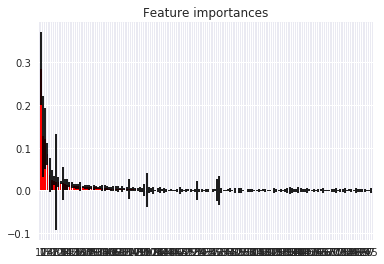

In [40]:
#exibe os principais atributos de cada árvore produzida no ensemble

std = np.std([est.steps[1][1].feature_importances_ for est in ensemble.estimators_], axis=0)

for estimator in ensemble.estimators_:
    feature_ranking(Xtest, estimator.steps[1][1], std)
    break
    


In [ ]:
#seleciona os melhores atributos para cada modelo
#não há como aplicar a técnica RFECV uma vez que o ensemble não gera um ranking geral das features
#selector = RFECV(ensemble, cv=10, n_jobs=-1)
#selector.fit(Xtest, ytest)

#best_columns = list(X.columns[selector.support_])
#print("Best Columns \n{}\n".format(best_columns))    


# Cenário 03: teste com RandomForest com o atributo class_weight='balanced'

{'n_estimators': 200}
0.9229596188087402
             precision    recall  f1-score   support

          0       0.88      0.34      0.50        87
          1       0.97      1.00      0.98      1843

avg / total       0.97      0.97      0.96      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


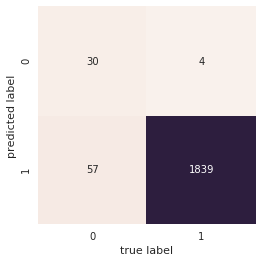

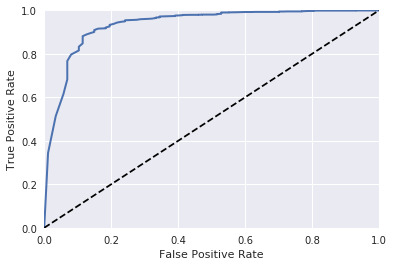

AUC: 0.934150


In [41]:
parameters = {'n_estimators': (10, 30, 100, 200)}

grid = GridSearchCV(RandomForestClassifier(max_features='auto', class_weight='balanced'),
             parameters,
             scoring="roc_auc")

#treina
grid.fit(Xtrain, ytrain)

#exibe melhor classificador
print(grid.best_params_)
print(grid.best_score_)
ensemble = grid.best_estimator_

#predicao
ypred_ensemble = ensemble.predict(Xtest)

#avaliação
evaluating(ensemble, ytest, ypred_ensemble, Xtest)

# Cenário 04: utilizando a técnica de BALANCED CASCADE + Ensemble Personalizado

Referências:
- https://pt.slideshare.net/PyData/python-resampling-65637486 
- https://www.youtube.com/watch?v=-Z1PaqYKC1w

In [42]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from imblearn.ensemble import BalanceCascade
import numpy as np
import operator
from sklearn.base import clone

class MyEnsembleClassifier(BaseEstimator, ClassifierMixin):
    """
    Ensemble classifier for scikit-learn estimators.

    Parameters
    ----------

    estimator : técnica de ML base para treinamento
    weights : `list` (default: `None`)
      If `None`, the majority rule voting will be applied to the predicted class labels.
        If a list of weights (`float` or `int`) is provided, the averaged raw probabilities (via `predict_proba`)
        will be used to determine the most confident class label.

    """
    
    def __init__(self, estimator = DecisionTreeClassifier(max_features='auto'), weights=None):
        
        self.estimator = estimator
        self.weights   = weights
        self.balanced  = BalanceCascade(estimator=estimator)
        self.clfs = []
        self.classes_ =[0, 1]
        
    def fit(self, X, y):
        """
        Fit the scikit-learn estimators utilizando como conjunto de treinamento os dados gerados a partir do BalanceCascade

        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]
            Training data
        y : list or numpy array, shape = [n_samples]
            Class labels

        """
        
        #separa o conjunto de treinamento para cada classificador
        X_train_res, y_train_res = self.balanced.fit_sample(X, y)
        
        #para cada classificador realizar o treinamento
        for idx in range(len(y_train_res)):    
            #clona o classificador definido
            clf = clone(self.estimator)
                
            #treina
            clf.fit(X_train_res[idx], y_train_res[idx]) 
            self.clfs.append( clf )        


    def predict(self, X):
        """
        Realiza a predição de acordo com a votação de cada classificador. Caso fique abaixo de 0.5 será selecionado a classe 01. 
        
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]

        Returns
        ----------

        maj : list or numpy array, shape = [n_samples]
            Predicted class labels by majority rule

        """
        
        #y_pred_cum = np.zeros( X.shape[0] )
        
        #for clf in self.clfs:            
        #    y_pred_cum += clf.predict_proba(X)[:, 0]
            
        #y_pred_cum = y_pred_cum/len(self.clfs)
        #maj = (y_pred_cum < 0.5).astype(int)

        
        maj = (self.predict_proba(X) < 0.5)[:, 0].astype(int)
        
        return maj

    def predict_proba(self, X):

        """
        Parameters
        ----------

        X : numpy array, shape = [n_samples, n_features]

        Returns
        ----------

        avg : list or numpy array, shape = [n_samples, n_probabilities]
            Weighted average probability for each class per sample.

        """
        #para cada classificador gera as probabilidades de cada classe
        self.probas_ = [clf.predict_proba(X) for clf in self.clfs]
        
        #retorna a média das probabilidades geradas
        avg = np.average(self.probas_, axis=0, weights=self.weights)

        return avg

             precision    recall  f1-score   support

          0       0.26      0.86      0.40        87
          1       0.99      0.89      0.94      1843

avg / total       0.96      0.89      0.91      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


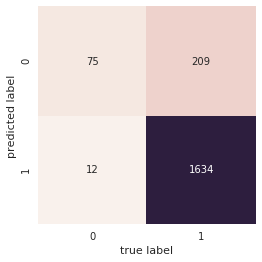

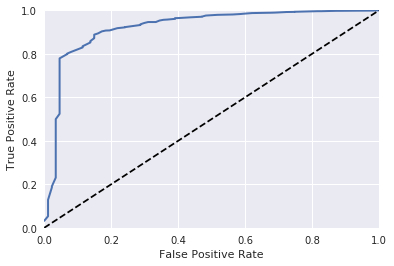

AUC: 0.921835


In [43]:
#cria o ensemble
myEns = MyEnsembleClassifier()

#treina
myEns.fit(Xtrain, ytrain)

#predição
ypred_vote = myEns.predict(Xtest)

#avaliação 
evaluating(myEns, ytest, ypred_vote, Xtest)

# Cenário 05: outras técnicas
Referência: 
- https://amueller.github.io/COMS4995-s18/slides/aml-13-022818-resampling-imbalanced-data/#16

In [44]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegressionCV
from imblearn.pipeline import make_pipeline as make_imb_pipeline

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(Xtrain, ytrain)

print(Xtrain.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegressionCV())

scores = cross_validate(undersample_pipe,
                        Xtrain, ytrain, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(5788, 151)
(524, 151)
[262 262]


(0.9023530635012473, 0.993507830248948)

             precision    recall  f1-score   support

          0       0.25      0.85      0.39        87
          1       0.99      0.88      0.93      1843

avg / total       0.96      0.88      0.91      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


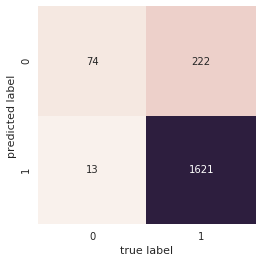

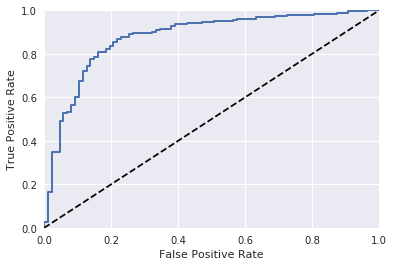

AUC: 0.877243


In [46]:
#treino
undersample_pipe.fit(Xtrain, ytrain)

#predicao
ypred = undersample_pipe.predict(Xtest)

#avaliação 
evaluating(undersample_pipe, ytest, ypred, Xtest)

             precision    recall  f1-score   support

          0       0.25      0.79      0.38        87
          1       0.99      0.89      0.94      1843

avg / total       0.96      0.88      0.91      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


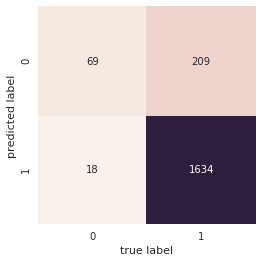

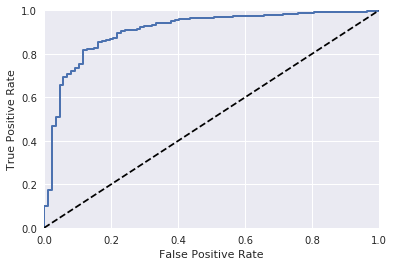

AUC: 0.907404


In [47]:
undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(),
                                        RandomForestClassifier())

#treino
undersample_pipe.fit(Xtrain, ytrain)

#predicao
ypred = undersample_pipe.predict(Xtest)

#avaliação 
evaluating(undersample_pipe, ytest, ypred, Xtest)

             precision    recall  f1-score   support

          0       0.25      0.84      0.38        87
          1       0.99      0.88      0.93      1843

avg / total       0.96      0.88      0.91      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


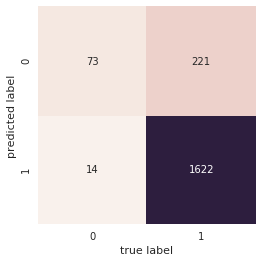

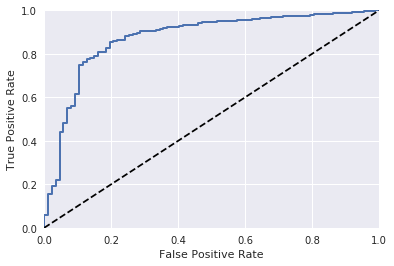

AUC: 0.873757


In [49]:
from sklearn.linear_model import LogisticRegression

#ensemble
undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(),
                                        LogisticRegression(class_weight='balanced'))

#treino
undersample_pipe.fit(Xtrain, ytrain)

#predicao
ypred = undersample_pipe.predict(Xtest)

#avaliação 
evaluating(undersample_pipe, ytest, ypred, Xtest)

In [50]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(n_neighbors=5)

X_train_enn, y_train_enn = enn.fit_sample(Xtrain, ytrain)

enn_mode = EditedNearestNeighbours(kind_sel="mode", n_neighbors=5)

X_train_enn_mode, y_train_enn_mode = enn_mode.fit_sample(Xtrain, ytrain)

             precision    recall  f1-score   support

          0       0.26      0.87      0.40        87
          1       0.99      0.88      0.94      1843

avg / total       0.96      0.88      0.91      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


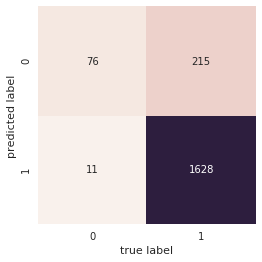

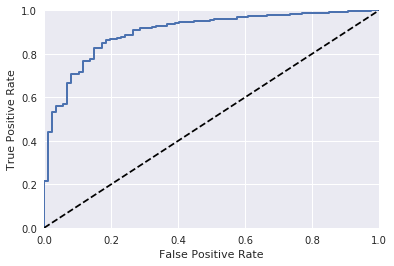

AUC: 0.902308


In [51]:
#ensemble
undersample_pipe_rf = make_imb_pipeline(EditedNearestNeighbours(n_neighbors=5),
                             LogisticRegression())

#treino
undersample_pipe.fit(Xtrain, ytrain)

#predicao
ypred = undersample_pipe.predict(Xtest)

#avaliação 
evaluating(undersample_pipe, ytest, ypred, Xtest)

             precision    recall  f1-score   support

          0       0.25      0.84      0.38        87
          1       0.99      0.88      0.93      1843

avg / total       0.96      0.88      0.91      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


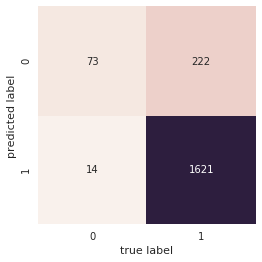

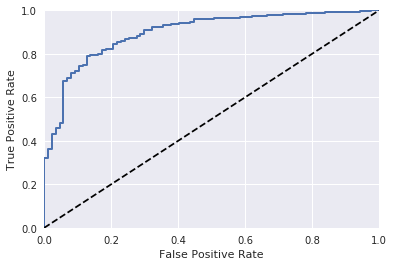

AUC: 0.897350


In [52]:
#ensemble
undersample_pipe_rf = make_imb_pipeline(EditedNearestNeighbours(n_neighbors= 5),
                                  RandomForestClassifier(n_estimators=100))

#treino
undersample_pipe.fit(Xtrain, ytrain)

#predicao
ypred = undersample_pipe.predict(Xtest)

#avaliação 
evaluating(undersample_pipe, ytest, ypred, Xtest)

In [53]:
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour()
X_train_cnn, y_train_cnn = cnn.fit_sample(Xtrain, ytrain)
print(X_train_cnn.shape)
print(np.bincount(y_train_cnn))

(907, 151)
[262 645]


             precision    recall  f1-score   support

          0       0.24      0.84      0.37        87
          1       0.99      0.87      0.93      1843

avg / total       0.96      0.87      0.90      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


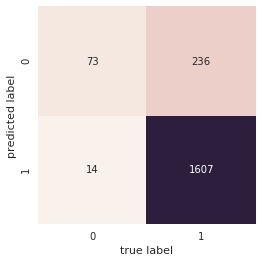

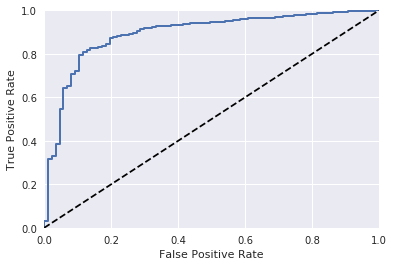

AUC: 0.893396


In [54]:
#ensemble
undersample_pipe_rf = make_imb_pipeline(CondensedNearestNeighbour(), LogisticRegression())

#treino
undersample_pipe.fit(Xtrain, ytrain)

#predicao
ypred = undersample_pipe.predict(Xtest)

#avaliação 
evaluating(undersample_pipe, ytest, ypred, Xtest)

             precision    recall  f1-score   support

          0       0.24      0.84      0.38        87
          1       0.99      0.88      0.93      1843

avg / total       0.96      0.87      0.91      1930



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


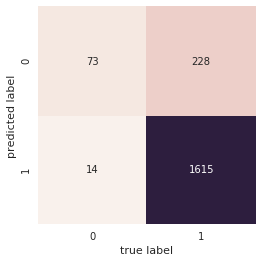

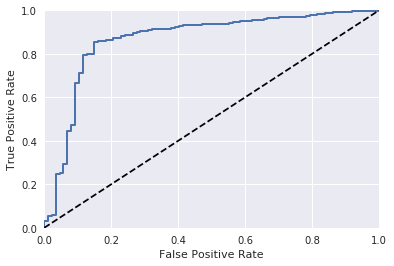

AUC: 0.866765


In [55]:
#ensemble
undersample_pipe_rf = make_imb_pipeline(CondensedNearestNeighbour(),
                              RandomForestClassifier(n_estimators=100))

#treino
undersample_pipe.fit(Xtrain, ytrain)

#predicao
ypred = undersample_pipe.predict(Xtest)

#avaliação 
evaluating(undersample_pipe, ytest, ypred, Xtest)